# Import Packages

In [1]:
#Import required packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
import os
os.listdir("test_images/")

['Challenge_image1.jpg',
 'Challenge_image2.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

# Read an image

X: 960 Y: 540
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


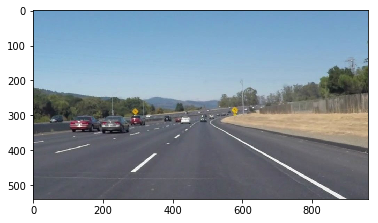

In [3]:
#Read image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#Grab the x and y size 
ysize = image.shape[0]
xsize = image.shape[1]
print('X:',xsize,'Y:',ysize)
    
#Print stats and plot
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

# Make copy of image and convert to grayscale image

In [4]:
def convertToHSL(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

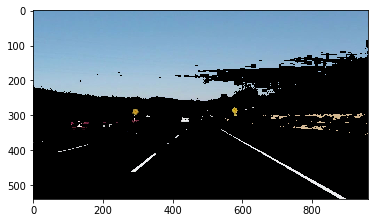

In [5]:
def filterWhiteYellow(image):
    #Make a copy of the original image
    #image_initial = np.copy(image)
    
    imageHSL = convertToHSL(image)
    # white color mask
    white_lower = np.uint8([  0, 190,   0])
    white_upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(imageHSL, white_lower, white_upper)
    
    # yellow color mask
    yellow_lower = np.uint8([ 0,   0, 100])
    yellow_upper = np.uint8([ 150, 255, 255])
    yellow_mask = cv2.inRange(imageHSL, yellow_lower, yellow_upper)
    
    # combine the mask
    mask_combined = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask_combined)
    return masked_image

filterImage = filterWhiteYellow(image)
plt.imshow(filterImage)

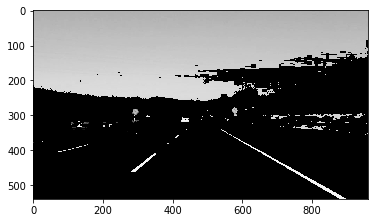

In [6]:
def grayscale(image):       
    #Convert image to grayscale
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    
grayImage = grayscale(filterImage)
#print('This image is:', type(gray_image), 'with dimensions:', gray_image.shape)
plt.imshow(grayImage, cmap='Greys_r')   

# Gaussian Blur and Canny edge detection

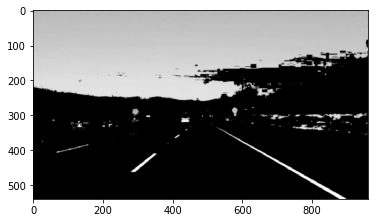

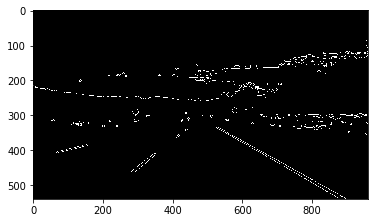

In [7]:
low_threshold = 50
high_threshold = 150
kernel_size = 7

def gaussianBlur(image, kernel_size):
    #Apply a Gaussian Noise kernel
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def canny(image, low_threshold, high_threshold):
    #Apply Canny transform
    return cv2.Canny(image, low_threshold, high_threshold)

# Display the image 
blurImage = gaussianBlur(grayImage, kernel_size)
plt.imshow(blurImage, cmap='Greys_r')
plt.show()

edgeImage= canny(blurImage, low_threshold, high_threshold)
plt.imshow(edgeImage, cmap='Greys_r')

# Region of interest

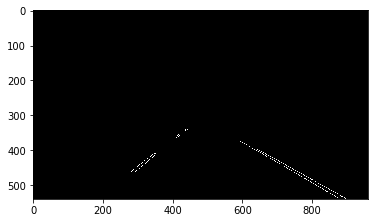

In [8]:
# first, define the polygon by vertices
#ysize, xsize = image.shape[:2]
bottomLeft  = [0, ysize]
topLeft     = [xsize*0.45, ysize*0.6]
topRight    = [xsize*0.5, ysize*0.6] 
bottomRight = [xsize, ysize]

yLimit = int(ysize*0.6) #Top endpoint of ROI on the Y axis

# the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
vertices = np.array([[bottomLeft, topLeft, topRight, bottomRight]], dtype=np.int32)
    
def regionOfInterest(image, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(image)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

ROIImage = regionOfInterest(edgeImage,vertices)
plt.imshow(ROIImage, cmap='Greys_r')
#print(yLimit)

# Hough Transform

In [9]:
def average(lines):
    
    leftLane = np.empty([1,3])  #slope,intercept,length
    rightLane = np.empty([1,3]) #slope,intercept,length
    
    ## calculate slopes for each line to identify the positive and negative lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0 and length > 10:
                leftLane = np.append(leftLane,np.array([[slope, intercept, length]]),axis = 0)
            elif slope > 0 and length > 10:
                rightLane = np.append(rightLane,np.array([[slope, intercept, length]]),axis = 0)
            else:
                pass
    
    ## just keep the observations with slopes with 1.5 std dev
    #leftLane = leftLane[to_keep_index(leftLane[:,0])]
    #rightLane = rightLane[to_keep_index(rightLane[:,0])]
    
    ## weighted average of the slopes and intercepts based on the length of the line segment
    leftLine = np.dot(leftLane[1:,2],leftLane[1:,:2])/np.sum(leftLane[1:,2]) if len(leftLane[1:,2]) > 0 else None
    rightLine = np.dot(rightLane[1:,2],rightLane[1:,:2])/np.sum(rightLane[1:,2]) if len(rightLane[1:,2]) > 0 else None
    
    #value = leftLine, rightLine
    #print(value)
    return leftLine, rightLine

#slopes_intercepts = average(houghLaneLinesImage)
#print(slopes_intercepts)
#print(slopes_intercepts[1][1])

In [10]:
def findEndpoints(image, intercepts):

    imshape = image.shape 
    
    if None not in intercepts:
        leftLaneLine = [0, np.int(intercepts[0][0]*0 + intercepts[0][1]),np.int(imshape[1]*0.45), np.int(intercepts[0][0]*np.int(imshape[1]*0.45) + intercepts[0][1])]
        rightLaneLine = [np.int(imshape[1]*0.5), np.int(intercepts[1][0]*imshape[1]*0.5 + intercepts[1][1]), imshape[1], np.int(intercepts[1][0]*imshape[1] + intercepts[1][1])]
    else:
        return None

    #value = leftLaneLine, rightLaneLine
    #print(value)
    return [leftLaneLine, rightLaneLine]

In [11]:
def drawLaneLines(image, endpoints, color = [0,0,255], thickness = 15):
    
    line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

    ## obtain slopes, intercepts, and endpoints of the weighted average line segments
    if endpoints is not None:
        for line in endpoints:
            
            ## draw lane lines
            cv2.line(image, (line[0],line[1]), (line[2],line[3]), color, thickness)
            
    return line_image

In [12]:
# Define the Hough transform parameters
rho = 1
theta = np.pi/180
threshold = 50
min_line_len = 50
max_line_gap = 200 
    
def houghLaneLines(image, rho, theta, threshold, min_line_len, max_line_gap):
    return cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

def weightedImage(image, initial_image, α=0.5, β=1., γ=0.):
    return cv2.addWeighted(initial_image, α, image, β, γ)

#houghImage = houghLines(ROIImage, rho, theta, threshold, min_line_len, max_line_gap)
#houghLaneLinesImage = houghLaneLines(ROIImage, rho, theta, threshold, min_line_len, max_line_gap)

#plt.imshow(houghImage, cmap="gray")
#plt.show()
#plt.imshow(houghLaneLinesImage, cmap="gray")
#plt.show()

#houghImagecombo = weightedImage(houghImage,image_initial, α=0.5, β=1., γ=0.)
#houghLaneLinesImagecombo = weightedImage(houghLaneLinesImage,image_initial, α=0.5, β=1., γ=0.)
#plt.imshow(houghImagecombo)
#plt.show()
#plt.imshow(houghLaneLinesImagecombo)


# Main function

In [13]:
def process_image(image):
    
    #Grab the x and y size 
    ysize = image.shape[0]
    xsize = image.shape[1]
    print('X:',xsize,'Y:',ysize)
    
    # first, define the polygon by vertices
    #ysize, xsize = image.shape[:2]
    bottomLeft  = [0, ysize]
    topLeft     = [xsize*0.45, ysize*0.6]
    topRight    = [xsize*0.5, ysize*0.6] 
    bottomRight = [xsize, ysize]

    yLimit = int(ysize*0.6) #Top endpoint of ROI on the Y axis
    
    # Define the Hough transform parameters
    rho = 1
    theta = np.pi/180
    threshold = 50
    min_line_len = 50
    max_line_gap = 200 

    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottomLeft, topLeft, topRight, bottomRight]], dtype=np.int32)
    
    filterImg = filterWhiteYellow(image)
    gray = grayscale(filterImg)
    blur = gaussianBlur(gray, kernel_size)
    edges = canny(blur, low_threshold, high_threshold)
    roi = regionOfInterest(edges,vertices)
    hough = houghLaneLines(roi, rho, theta, threshold, min_line_len, max_line_gap)
    slopes_intercepts = average(hough)
    endpointsImage = findEndpoints(image, slopes_intercepts)
    laneLines = drawLaneLines(image, endpointsImage)
    result = weightedImage(laneLines, image, α=0.5, β=1., γ=0.)

    return result

Image Challenge_image1.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
X: 1280 Y: 720


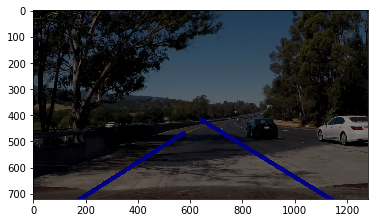

Image Challenge_image2.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
X: 1280 Y: 720


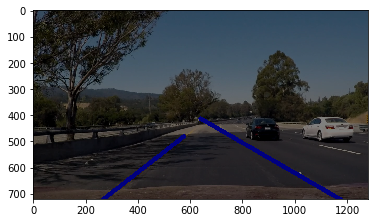

Image solidWhiteCurve.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
X: 960 Y: 540


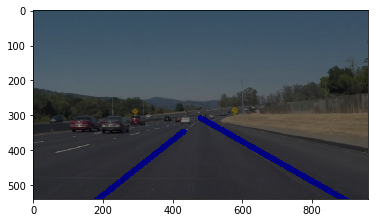

Image solidWhiteRight.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
X: 960 Y: 540


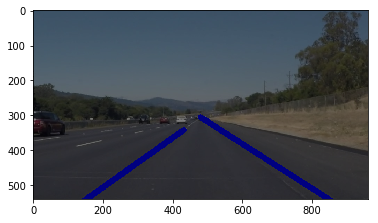

Image solidYellowCurve.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
X: 960 Y: 540


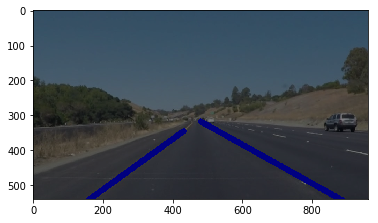

Image solidYellowCurve2.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
X: 960 Y: 540


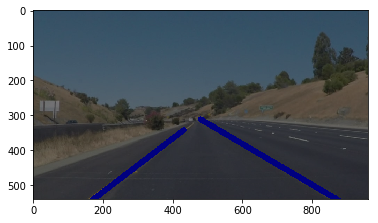

Image solidYellowLeft.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
X: 960 Y: 540


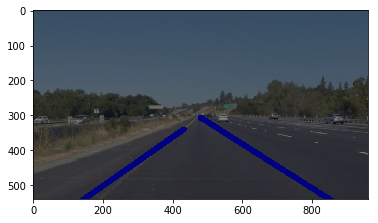

Image whiteCarLaneSwitch.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
X: 960 Y: 540


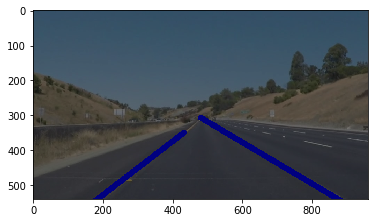

In [14]:
# Printing out test images with lane fill
for image_file in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + image_file)
    print('Image ' + image_file +' displayed below is:', type(image), 'with dimensions:', image.shape)
    processed_img = process_image(image)
    # mpimg.imsave('test_images_output/Processed_'+ image_file, processed_img) # Did this the first time
    plt.imshow(processed_img)
    plt.show()

##### Video

In [15]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

X: 960 Y: 540
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|                                                                                          | 0/222 [00:00<?, ?it/s]

X: 960 Y: 540


  0%|▎                                                                                 | 1/222 [00:00<01:16,  2.90it/s]

X: 960 Y: 540


  1%|▋                                                                                 | 2/222 [00:00<00:56,  3.92it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  2%|█▊                                                                                | 5/222 [00:00<00:26,  8.07it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  4%|██▉                                                                               | 8/222 [00:00<00:19, 10.95it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  5%|████                                                                             | 11/222 [00:00<00:16, 13.12it/s]

X: 960 Y: 540
X: 960 Y: 540


  6%|████▋                                                                            | 13/222 [00:00<00:15, 13.75it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  7%|█████▊                                                                           | 16/222 [00:01<00:13, 15.20it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  9%|██████▉                                                                          | 19/222 [00:01<00:12, 16.29it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 10%|████████                                                                         | 22/222 [00:01<00:11, 17.00it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 11%|█████████                                                                        | 25/222 [00:01<00:11, 17.26it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 13%|██████████▏                                                                      | 28/222 [00:01<00:10, 17.79it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 14%|███████████▎                                                                     | 31/222 [00:01<00:10, 18.47it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 15%|████████████▍                                                                    | 34/222 [00:01<00:09, 19.09it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 17%|█████████████▊                                                                   | 38/222 [00:01<00:09, 19.92it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 18%|██████████████▉                                                                  | 41/222 [00:02<00:08, 20.42it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 20%|████████████████                                                                 | 44/222 [00:02<00:08, 20.83it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 21%|█████████████████▏                                                               | 47/222 [00:02<00:08, 21.19it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 23%|██████████████████▏                                                              | 50/222 [00:02<00:07, 21.56it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 24%|███████████████████▎                                                             | 53/222 [00:02<00:07, 21.65it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 25%|████████████████████▍                                                            | 56/222 [00:02<00:07, 21.91it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 27%|█████████████████████▌                                                           | 59/222 [00:02<00:07, 22.04it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 28%|██████████████████████▌                                                          | 62/222 [00:02<00:07, 22.18it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 29%|███████████████████████▋                                                         | 65/222 [00:02<00:07, 22.29it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 31%|████████████████████████▊                                                        | 68/222 [00:03<00:06, 22.42it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 32%|█████████████████████████▉                                                       | 71/222 [00:03<00:06, 22.56it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 33%|███████████████████████████                                                      | 74/222 [00:03<00:06, 22.62it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 35%|████████████████████████████                                                     | 77/222 [00:03<00:06, 22.79it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 36%|█████████████████████████████▏                                                   | 80/222 [00:03<00:06, 22.85it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 37%|██████████████████████████████▎                                                  | 83/222 [00:03<00:06, 22.91it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 39%|███████████████████████████████▍                                                 | 86/222 [00:03<00:05, 22.88it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 40%|████████████████████████████████▍                                                | 89/222 [00:03<00:05, 22.93it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 41%|█████████████████████████████████▌                                               | 92/222 [00:04<00:05, 22.96it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 43%|██████████████████████████████████▋                                              | 95/222 [00:04<00:05, 22.95it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 44%|███████████████████████████████████▊                                             | 98/222 [00:04<00:05, 22.98it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 45%|████████████████████████████████████▍                                           | 101/222 [00:04<00:05, 22.96it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 47%|█████████████████████████████████████▍                                          | 104/222 [00:04<00:05, 22.96it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 48%|██████████████████████████████████████▌                                         | 107/222 [00:04<00:05, 22.97it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 50%|███████████████████████████████████████▋                                        | 110/222 [00:04<00:04, 22.92it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 51%|████████████████████████████████████████▋                                       | 113/222 [00:04<00:04, 22.89it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 52%|█████████████████████████████████████████▊                                      | 116/222 [00:05<00:04, 22.94it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 54%|██████████████████████████████████████████▉                                     | 119/222 [00:05<00:04, 22.96it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 55%|███████████████████████████████████████████▉                                    | 122/222 [00:05<00:04, 22.96it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 57%|█████████████████████████████████████████████▍                                  | 126/222 [00:05<00:04, 23.17it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 59%|██████████████████████████████████████████████▊                                 | 130/222 [00:05<00:03, 23.46it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 60%|████████████████████████████████████████████████▎                               | 134/222 [00:05<00:03, 23.73it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 62%|█████████████████████████████████████████████████▋                              | 138/222 [00:05<00:03, 23.91it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 64%|███████████████████████████████████████████████████▏                            | 142/222 [00:05<00:03, 24.07it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 66%|████████████████████████████████████████████████████▌                           | 146/222 [00:06<00:03, 24.08it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 67%|█████████████████████████████████████████████████████▋                          | 149/222 [00:06<00:03, 24.10it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 68%|██████████████████████████████████████████████████████▊                         | 152/222 [00:06<00:02, 24.10it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 70%|███████████████████████████████████████████████████████▊                        | 155/222 [00:06<00:02, 24.07it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 71%|████████████████████████████████████████████████████████▉                       | 158/222 [00:06<00:02, 24.08it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 73%|██████████████████████████████████████████████████████████                      | 161/222 [00:06<00:02, 24.08it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 74%|███████████████████████████████████████████████████████████                     | 164/222 [00:06<00:02, 24.10it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 75%|████████████████████████████████████████████████████████████▏                   | 167/222 [00:06<00:02, 24.14it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 77%|█████████████████████████████████████████████████████████████▎                  | 170/222 [00:07<00:02, 24.15it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 78%|██████████████████████████████████████████████████████████████▎                 | 173/222 [00:07<00:02, 24.14it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 79%|███████████████████████████████████████████████████████████████▍                | 176/222 [00:07<00:01, 24.13it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 81%|████████████████████████████████████████████████████████████████▌               | 179/222 [00:07<00:01, 24.12it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 82%|█████████████████████████████████████████████████████████████████▌              | 182/222 [00:07<00:01, 24.09it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 83%|██████████████████████████████████████████████████████████████████▋             | 185/222 [00:07<00:01, 24.07it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 85%|███████████████████████████████████████████████████████████████████▋            | 188/222 [00:07<00:01, 24.07it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 86%|████████████████████████████████████████████████████████████████████▊           | 191/222 [00:07<00:01, 24.05it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 87%|█████████████████████████████████████████████████████████████████████▉          | 194/222 [00:08<00:01, 24.01it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 89%|██████████████████████████████████████████████████████████████████████▉         | 197/222 [00:08<00:01, 23.97it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 90%|████████████████████████████████████████████████████████████████████████        | 200/222 [00:08<00:00, 23.96it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 91%|█████████████████████████████████████████████████████████████████████████▏      | 203/222 [00:08<00:00, 23.93it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 93%|██████████████████████████████████████████████████████████████████████████▏     | 206/222 [00:08<00:00, 23.92it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 94%|███████████████████████████████████████████████████████████████████████████▎    | 209/222 [00:08<00:00, 23.94it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 95%|████████████████████████████████████████████████████████████████████████████▍   | 212/222 [00:08<00:00, 23.97it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 215/222 [00:08<00:00, 23.98it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 218/222 [00:09<00:00, 23.99it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:09<00:00, 23.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 9.69 s


In [16]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'

clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

X: 960 Y: 540
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                                                                          | 0/682 [00:00<?, ?it/s]

X: 960 Y: 540
X: 960 Y: 540


  0%|▏                                                                                 | 2/682 [00:00<00:37, 18.19it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  1%|▌                                                                                 | 5/682 [00:00<00:31, 21.29it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  1%|▉                                                                                 | 8/682 [00:00<00:30, 22.24it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  2%|█▎                                                                               | 11/682 [00:00<00:28, 23.77it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  2%|█▋                                                                               | 14/682 [00:00<00:26, 24.79it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  3%|██▏                                                                              | 18/682 [00:00<00:26, 25.37it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  3%|██▍                                                                              | 21/682 [00:00<00:27, 24.40it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  4%|██▊                                                                              | 24/682 [00:00<00:26, 24.48it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  4%|███▏                                                                             | 27/682 [00:01<00:26, 24.74it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  4%|███▌                                                                             | 30/682 [00:01<00:26, 24.46it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  5%|███▉                                                                             | 33/682 [00:01<00:27, 23.89it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  5%|████▎                                                                            | 36/682 [00:01<00:27, 23.90it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  6%|████▋                                                                            | 39/682 [00:01<00:26, 24.07it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  6%|████▉                                                                            | 42/682 [00:01<00:26, 24.08it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  7%|█████▎                                                                           | 45/682 [00:01<00:26, 23.61it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  7%|█████▋                                                                           | 48/682 [00:02<00:26, 23.54it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  7%|██████                                                                           | 51/682 [00:02<00:26, 23.76it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  8%|██████▍                                                                          | 54/682 [00:02<00:26, 23.96it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  8%|██████▊                                                                          | 57/682 [00:02<00:26, 24.03it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  9%|███████▏                                                                         | 60/682 [00:02<00:25, 24.15it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


  9%|███████▍                                                                         | 63/682 [00:02<00:25, 24.18it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 10%|███████▊                                                                         | 66/682 [00:02<00:25, 23.95it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 10%|████████▏                                                                        | 69/682 [00:02<00:25, 23.80it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 11%|████████▌                                                                        | 72/682 [00:03<00:25, 23.74it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 11%|████████▉                                                                        | 75/682 [00:03<00:25, 23.78it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 11%|█████████▎                                                                       | 78/682 [00:03<00:25, 23.82it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 12%|█████████▌                                                                       | 81/682 [00:03<00:25, 23.78it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 12%|█████████▉                                                                       | 84/682 [00:03<00:25, 23.83it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 13%|██████████▎                                                                      | 87/682 [00:03<00:24, 23.82it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 13%|██████████▋                                                                      | 90/682 [00:03<00:24, 23.69it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 14%|███████████                                                                      | 93/682 [00:03<00:24, 23.64it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 14%|███████████▍                                                                     | 96/682 [00:04<00:24, 23.62it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 15%|███████████▊                                                                     | 99/682 [00:04<00:24, 23.60it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 15%|███████████▉                                                                    | 102/682 [00:04<00:24, 23.54it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 15%|████████████▎                                                                   | 105/682 [00:04<00:24, 23.52it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 16%|████████████▋                                                                   | 108/682 [00:04<00:24, 23.47it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 16%|█████████████                                                                   | 111/682 [00:04<00:24, 23.48it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 17%|█████████████▎                                                                  | 114/682 [00:04<00:24, 23.46it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 17%|█████████████▋                                                                  | 117/682 [00:04<00:24, 23.43it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 18%|██████████████                                                                  | 120/682 [00:05<00:23, 23.43it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 18%|██████████████▍                                                                 | 123/682 [00:05<00:23, 23.39it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 18%|██████████████▊                                                                 | 126/682 [00:05<00:23, 23.39it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 19%|███████████████▏                                                                | 129/682 [00:05<00:23, 23.37it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 19%|███████████████▍                                                                | 132/682 [00:05<00:23, 23.38it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 20%|███████████████▊                                                                | 135/682 [00:05<00:23, 23.39it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 20%|████████████████▏                                                               | 138/682 [00:05<00:23, 23.37it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 21%|████████████████▌                                                               | 141/682 [00:06<00:23, 23.35it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 21%|████████████████▉                                                               | 144/682 [00:06<00:23, 23.36it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 22%|█████████████████▏                                                              | 147/682 [00:06<00:22, 23.35it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 22%|█████████████████▌                                                              | 150/682 [00:06<00:22, 23.39it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 22%|█████████████████▉                                                              | 153/682 [00:06<00:22, 23.39it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 23%|██████████████████▎                                                             | 156/682 [00:06<00:22, 23.38it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 23%|██████████████████▋                                                             | 159/682 [00:06<00:22, 23.41it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 24%|███████████████████                                                             | 162/682 [00:06<00:22, 23.43it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 24%|███████████████████▎                                                            | 165/682 [00:07<00:22, 23.44it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 25%|███████████████████▋                                                            | 168/682 [00:07<00:21, 23.44it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 25%|████████████████████                                                            | 171/682 [00:07<00:21, 23.47it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 26%|████████████████████▍                                                           | 174/682 [00:07<00:21, 23.49it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 26%|████████████████████▊                                                           | 177/682 [00:07<00:21, 23.53it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 26%|█████████████████████                                                           | 180/682 [00:07<00:21, 23.56it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 27%|█████████████████████▍                                                          | 183/682 [00:07<00:21, 23.61it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 27%|█████████████████████▊                                                          | 186/682 [00:07<00:20, 23.65it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 28%|██████████████████████▏                                                         | 189/682 [00:07<00:20, 23.68it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 28%|██████████████████████▌                                                         | 192/682 [00:08<00:20, 23.73it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 29%|██████████████████████▊                                                         | 195/682 [00:08<00:20, 23.75it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 29%|███████████████████████▏                                                        | 198/682 [00:08<00:20, 23.78it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 29%|███████████████████████▌                                                        | 201/682 [00:08<00:20, 23.84it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 30%|███████████████████████▉                                                        | 204/682 [00:08<00:20, 23.87it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 30%|████████████████████████▎                                                       | 207/682 [00:08<00:19, 23.89it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 31%|████████████████████████▋                                                       | 210/682 [00:08<00:19, 23.90it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 31%|████████████████████████▉                                                       | 213/682 [00:08<00:19, 23.91it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 32%|█████████████████████████▎                                                      | 216/682 [00:09<00:19, 23.95it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 32%|█████████████████████████▋                                                      | 219/682 [00:09<00:19, 23.95it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 33%|██████████████████████████                                                      | 222/682 [00:09<00:19, 23.96it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 33%|██████████████████████████▍                                                     | 225/682 [00:09<00:19, 23.96it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 33%|██████████████████████████▋                                                     | 228/682 [00:09<00:18, 23.99it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 34%|███████████████████████████                                                     | 231/682 [00:09<00:18, 24.02it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 34%|███████████████████████████▍                                                    | 234/682 [00:09<00:18, 24.05it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 35%|███████████████████████████▊                                                    | 237/682 [00:09<00:18, 24.09it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 35%|████████████████████████████▏                                                   | 240/682 [00:09<00:18, 24.12it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 36%|████████████████████████████▌                                                   | 243/682 [00:10<00:18, 24.14it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 36%|████████████████████████████▊                                                   | 246/682 [00:10<00:18, 24.19it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 37%|█████████████████████████████▏                                                  | 249/682 [00:10<00:17, 24.20it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 37%|█████████████████████████████▌                                                  | 252/682 [00:10<00:17, 24.23it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 37%|█████████████████████████████▉                                                  | 255/682 [00:10<00:17, 24.25it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 38%|██████████████████████████████▎                                                 | 258/682 [00:10<00:17, 24.28it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 38%|██████████████████████████████▌                                                 | 261/682 [00:10<00:17, 24.30it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 39%|██████████████████████████████▉                                                 | 264/682 [00:10<00:17, 24.28it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 39%|███████████████████████████████▎                                                | 267/682 [00:10<00:17, 24.31it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 40%|███████████████████████████████▋                                                | 270/682 [00:11<00:16, 24.34it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 40%|████████████████████████████████                                                | 273/682 [00:11<00:16, 24.38it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 40%|████████████████████████████████▍                                               | 276/682 [00:11<00:16, 24.41it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 41%|████████████████████████████████▋                                               | 279/682 [00:11<00:16, 24.42it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 41%|█████████████████████████████████                                               | 282/682 [00:11<00:16, 24.44it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 42%|█████████████████████████████████▍                                              | 285/682 [00:11<00:16, 24.46it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 42%|█████████████████████████████████▊                                              | 288/682 [00:11<00:16, 24.50it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 43%|██████████████████████████████████▏                                             | 291/682 [00:11<00:15, 24.51it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 43%|██████████████████████████████████▍                                             | 294/682 [00:11<00:15, 24.53it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 44%|██████████████████████████████████▊                                             | 297/682 [00:12<00:15, 24.55it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 44%|███████████████████████████████████▏                                            | 300/682 [00:12<00:15, 24.57it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 44%|███████████████████████████████████▌                                            | 303/682 [00:12<00:15, 24.61it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 45%|███████████████████████████████████▉                                            | 306/682 [00:12<00:15, 24.60it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 45%|████████████████████████████████████▏                                           | 309/682 [00:12<00:15, 24.63it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 46%|████████████████████████████████████▌                                           | 312/682 [00:12<00:15, 24.63it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 46%|████████████████████████████████████▉                                           | 315/682 [00:12<00:14, 24.65it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 47%|█████████████████████████████████████▎                                          | 318/682 [00:12<00:14, 24.66it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 47%|█████████████████████████████████████▋                                          | 321/682 [00:13<00:14, 24.67it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 48%|██████████████████████████████████████                                          | 324/682 [00:13<00:14, 24.68it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 48%|██████████████████████████████████████▎                                         | 327/682 [00:13<00:14, 24.69it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 48%|██████████████████████████████████████▋                                         | 330/682 [00:13<00:14, 24.68it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 49%|███████████████████████████████████████                                         | 333/682 [00:13<00:14, 24.67it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 49%|███████████████████████████████████████▍                                        | 336/682 [00:13<00:14, 24.66it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 50%|███████████████████████████████████████▊                                        | 339/682 [00:13<00:13, 24.65it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 50%|████████████████████████████████████████                                        | 342/682 [00:13<00:13, 24.66it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 51%|████████████████████████████████████████▍                                       | 345/682 [00:13<00:13, 24.65it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 51%|████████████████████████████████████████▊                                       | 348/682 [00:14<00:13, 24.64it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 51%|█████████████████████████████████████████▏                                      | 351/682 [00:14<00:13, 24.66it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 52%|█████████████████████████████████████████▌                                      | 354/682 [00:14<00:13, 24.66it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 52%|█████████████████████████████████████████▉                                      | 357/682 [00:14<00:13, 24.67it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 53%|██████████████████████████████████████████▏                                     | 360/682 [00:14<00:13, 24.66it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 53%|██████████████████████████████████████████▌                                     | 363/682 [00:14<00:12, 24.67it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 54%|██████████████████████████████████████████▉                                     | 366/682 [00:14<00:12, 24.67it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 54%|███████████████████████████████████████████▎                                    | 369/682 [00:14<00:12, 24.67it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 55%|███████████████████████████████████████████▋                                    | 372/682 [00:15<00:12, 24.67it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 55%|███████████████████████████████████████████▉                                    | 375/682 [00:15<00:12, 24.67it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 55%|████████████████████████████████████████████▎                                   | 378/682 [00:15<00:12, 24.68it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 56%|████████████████████████████████████████████▋                                   | 381/682 [00:15<00:12, 24.69it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 56%|█████████████████████████████████████████████                                   | 384/682 [00:15<00:12, 24.68it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 57%|█████████████████████████████████████████████▍                                  | 387/682 [00:15<00:11, 24.69it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 57%|█████████████████████████████████████████████▋                                  | 390/682 [00:15<00:11, 24.70it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 58%|██████████████████████████████████████████████                                  | 393/682 [00:15<00:11, 24.70it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 58%|██████████████████████████████████████████████▍                                 | 396/682 [00:16<00:11, 24.70it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 59%|██████████████████████████████████████████████▊                                 | 399/682 [00:16<00:11, 24.71it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 59%|███████████████████████████████████████████████▏                                | 402/682 [00:16<00:11, 24.70it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 59%|███████████████████████████████████████████████▌                                | 405/682 [00:16<00:11, 24.70it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 60%|███████████████████████████████████████████████▊                                | 408/682 [00:16<00:11, 24.69it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 60%|████████████████████████████████████████████████▏                               | 411/682 [00:16<00:10, 24.69it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 61%|████████████████████████████████████████████████▌                               | 414/682 [00:16<00:10, 24.69it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 61%|████████████████████████████████████████████████▉                               | 417/682 [00:16<00:10, 24.68it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 62%|█████████████████████████████████████████████████▎                              | 420/682 [00:17<00:10, 24.68it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 62%|█████████████████████████████████████████████████▌                              | 423/682 [00:17<00:10, 24.66it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 62%|█████████████████████████████████████████████████▉                              | 426/682 [00:17<00:10, 24.65it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 63%|██████████████████████████████████████████████████▎                             | 429/682 [00:17<00:10, 24.64it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 63%|██████████████████████████████████████████████████▋                             | 432/682 [00:17<00:10, 24.66it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 64%|███████████████████████████████████████████████████                             | 435/682 [00:17<00:10, 24.65it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 64%|███████████████████████████████████████████████████▍                            | 438/682 [00:17<00:09, 24.63it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 65%|███████████████████████████████████████████████████▋                            | 441/682 [00:17<00:09, 24.61it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 65%|████████████████████████████████████████████████████                            | 444/682 [00:18<00:09, 24.59it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 66%|████████████████████████████████████████████████████▍                           | 447/682 [00:18<00:09, 24.58it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 66%|████████████████████████████████████████████████████▊                           | 450/682 [00:18<00:09, 24.57it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 66%|█████████████████████████████████████████████████████▏                          | 453/682 [00:18<00:09, 24.55it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 67%|█████████████████████████████████████████████████████▍                          | 456/682 [00:18<00:09, 24.53it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 67%|█████████████████████████████████████████████████████▊                          | 459/682 [00:18<00:09, 24.52it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 68%|██████████████████████████████████████████████████████▏                         | 462/682 [00:18<00:08, 24.52it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 68%|██████████████████████████████████████████████████████▌                         | 465/682 [00:18<00:08, 24.50it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 69%|██████████████████████████████████████████████████████▉                         | 468/682 [00:19<00:08, 24.50it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 69%|███████████████████████████████████████████████████████▏                        | 471/682 [00:19<00:08, 24.49it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 70%|███████████████████████████████████████████████████████▌                        | 474/682 [00:19<00:08, 24.50it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 70%|███████████████████████████████████████████████████████▉                        | 477/682 [00:19<00:08, 24.50it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 70%|████████████████████████████████████████████████████████▎                       | 480/682 [00:19<00:08, 24.49it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 71%|████████████████████████████████████████████████████████▋                       | 483/682 [00:19<00:08, 24.50it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 71%|█████████████████████████████████████████████████████████                       | 486/682 [00:19<00:08, 24.49it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 72%|█████████████████████████████████████████████████████████▎                      | 489/682 [00:19<00:07, 24.48it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 72%|█████████████████████████████████████████████████████████▋                      | 492/682 [00:20<00:07, 24.46it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 73%|██████████████████████████████████████████████████████████                      | 495/682 [00:20<00:07, 24.45it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 73%|██████████████████████████████████████████████████████████▍                     | 498/682 [00:20<00:07, 24.45it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 73%|██████████████████████████████████████████████████████████▊                     | 501/682 [00:20<00:07, 24.45it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 74%|███████████████████████████████████████████████████████████                     | 504/682 [00:20<00:07, 24.46it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 74%|███████████████████████████████████████████████████████████▍                    | 507/682 [00:20<00:07, 24.44it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 75%|███████████████████████████████████████████████████████████▊                    | 510/682 [00:20<00:07, 24.43it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 75%|████████████████████████████████████████████████████████████▏                   | 513/682 [00:21<00:06, 24.40it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 76%|████████████████████████████████████████████████████████████▌                   | 516/682 [00:21<00:06, 24.40it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 76%|████████████████████████████████████████████████████████████▉                   | 519/682 [00:21<00:06, 24.17it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 77%|█████████████████████████████████████████████████████████████▏                  | 522/682 [00:21<00:06, 24.15it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 77%|█████████████████████████████████████████████████████████████▌                  | 525/682 [00:21<00:06, 24.15it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 77%|█████████████████████████████████████████████████████████████▉                  | 528/682 [00:21<00:06, 24.14it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 78%|██████████████████████████████████████████████████████████████▎                 | 531/682 [00:21<00:06, 24.14it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 78%|██████████████████████████████████████████████████████████████▋                 | 534/682 [00:22<00:06, 24.13it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 79%|██████████████████████████████████████████████████████████████▉                 | 537/682 [00:22<00:06, 24.13it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 79%|███████████████████████████████████████████████████████████████▎                | 540/682 [00:22<00:05, 24.14it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 80%|███████████████████████████████████████████████████████████████▋                | 543/682 [00:22<00:05, 24.13it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 80%|████████████████████████████████████████████████████████████████                | 546/682 [00:22<00:05, 24.13it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 80%|████████████████████████████████████████████████████████████████▍               | 549/682 [00:22<00:05, 24.12it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 81%|████████████████████████████████████████████████████████████████▊               | 552/682 [00:22<00:05, 24.10it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 81%|█████████████████████████████████████████████████████████████████               | 555/682 [00:23<00:05, 24.12it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 82%|█████████████████████████████████████████████████████████████████▍              | 558/682 [00:23<00:05, 24.13it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 82%|█████████████████████████████████████████████████████████████████▊              | 561/682 [00:23<00:05, 24.14it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 83%|██████████████████████████████████████████████████████████████████▏             | 564/682 [00:23<00:04, 24.16it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 83%|██████████████████████████████████████████████████████████████████▌             | 567/682 [00:23<00:04, 24.15it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 84%|██████████████████████████████████████████████████████████████████▊             | 570/682 [00:23<00:04, 24.17it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 84%|███████████████████████████████████████████████████████████████████▏            | 573/682 [00:23<00:04, 24.19it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 84%|███████████████████████████████████████████████████████████████████▌            | 576/682 [00:23<00:04, 24.20it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 85%|███████████████████████████████████████████████████████████████████▉            | 579/682 [00:23<00:04, 24.20it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 85%|████████████████████████████████████████████████████████████████████▎           | 582/682 [00:24<00:04, 24.20it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 86%|████████████████████████████████████████████████████████████████████▌           | 585/682 [00:24<00:04, 24.22it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 86%|████████████████████████████████████████████████████████████████████▉           | 588/682 [00:24<00:03, 24.23it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 87%|█████████████████████████████████████████████████████████████████████▎          | 591/682 [00:24<00:03, 24.25it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 87%|█████████████████████████████████████████████████████████████████████▋          | 594/682 [00:24<00:03, 24.26it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 88%|██████████████████████████████████████████████████████████████████████          | 597/682 [00:24<00:03, 24.28it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 88%|██████████████████████████████████████████████████████████████████████▍         | 600/682 [00:24<00:03, 24.28it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 88%|██████████████████████████████████████████████████████████████████████▋         | 603/682 [00:24<00:03, 24.28it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 89%|███████████████████████████████████████████████████████████████████████         | 606/682 [00:24<00:03, 24.29it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 89%|███████████████████████████████████████████████████████████████████████▍        | 609/682 [00:25<00:03, 24.28it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 90%|███████████████████████████████████████████████████████████████████████▊        | 612/682 [00:25<00:02, 24.27it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 90%|████████████████████████████████████████████████████████████████████████▏       | 615/682 [00:25<00:02, 24.28it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 91%|████████████████████████████████████████████████████████████████████████▍       | 618/682 [00:25<00:02, 24.29it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 91%|████████████████████████████████████████████████████████████████████████▊       | 621/682 [00:25<00:02, 24.31it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 91%|█████████████████████████████████████████████████████████████████████████▏      | 624/682 [00:25<00:02, 24.32it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 92%|█████████████████████████████████████████████████████████████████████████▌      | 627/682 [00:25<00:02, 24.32it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 92%|█████████████████████████████████████████████████████████████████████████▉      | 630/682 [00:25<00:02, 24.32it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 93%|██████████████████████████████████████████████████████████████████████████▎     | 633/682 [00:26<00:02, 24.32it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 93%|██████████████████████████████████████████████████████████████████████████▌     | 636/682 [00:26<00:01, 24.33it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 94%|██████████████████████████████████████████████████████████████████████████▉     | 639/682 [00:26<00:01, 24.34it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 94%|███████████████████████████████████████████████████████████████████████████▎    | 642/682 [00:26<00:01, 24.35it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 95%|███████████████████████████████████████████████████████████████████████████▋    | 645/682 [00:26<00:01, 24.36it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 95%|████████████████████████████████████████████████████████████████████████████    | 648/682 [00:26<00:01, 24.37it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 95%|████████████████████████████████████████████████████████████████████████████▎   | 651/682 [00:26<00:01, 24.36it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 96%|████████████████████████████████████████████████████████████████████████████▋   | 654/682 [00:26<00:01, 24.36it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 96%|█████████████████████████████████████████████████████████████████████████████   | 657/682 [00:26<00:01, 24.37it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 660/682 [00:27<00:00, 24.38it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 663/682 [00:27<00:00, 24.39it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 98%|██████████████████████████████████████████████████████████████████████████████  | 666/682 [00:27<00:00, 24.40it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 669/682 [00:27<00:00, 24.40it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 672/682 [00:27<00:00, 24.40it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 99%|███████████████████████████████████████████████████████████████████████████████▏| 675/682 [00:27<00:00, 24.41it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


 99%|███████████████████████████████████████████████████████████████████████████████▌| 678/682 [00:27<00:00, 24.43it/s]

X: 960 Y: 540
X: 960 Y: 540
X: 960 Y: 540


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:27<00:00, 24.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 28.4 s


In [17]:
challenge_output = 'test_videos_output/challenge.mp4'

clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

X: 1280 Y: 720
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

X: 1280 Y: 720
X: 1280 Y: 720


  1%|▋                                                                                 | 2/251 [00:00<00:16, 15.28it/s]

X: 1280 Y: 720
X: 1280 Y: 720


  2%|█▎                                                                                | 4/251 [00:00<00:15, 16.14it/s]

X: 1280 Y: 720
X: 1280 Y: 720


  2%|█▉                                                                                | 6/251 [00:00<00:15, 16.01it/s]

X: 1280 Y: 720
X: 1280 Y: 720


  3%|██▌                                                                               | 8/251 [00:00<00:15, 15.85it/s]

X: 1280 Y: 720
X: 1280 Y: 720


  4%|███▏                                                                             | 10/251 [00:00<00:15, 15.63it/s]

X: 1280 Y: 720
X: 1280 Y: 720


  5%|███▊                                                                             | 12/251 [00:00<00:15, 15.28it/s]

X: 1280 Y: 720
X: 1280 Y: 720


  6%|████▌                                                                            | 14/251 [00:00<00:15, 15.24it/s]

X: 1280 Y: 720
X: 1280 Y: 720


  6%|█████▏                                                                           | 16/251 [00:01<00:15, 15.25it/s]

X: 1280 Y: 720
X: 1280 Y: 720
X: 1280 Y: 720


  8%|██████▏                                                                          | 19/251 [00:01<00:14, 15.90it/s]

X: 1280 Y: 720
X: 1280 Y: 720


  8%|██████▊                                                                          | 21/251 [00:01<00:14, 15.74it/s]

X: 1280 Y: 720
X: 1280 Y: 720


  9%|███████▍                                                                         | 23/251 [00:01<00:14, 15.75it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 10%|████████                                                                         | 25/251 [00:01<00:14, 15.86it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 11%|████████▋                                                                        | 27/251 [00:01<00:13, 16.01it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 12%|█████████▎                                                                       | 29/251 [00:01<00:13, 16.12it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 12%|██████████                                                                       | 31/251 [00:01<00:13, 16.08it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 13%|██████████▋                                                                      | 33/251 [00:02<00:13, 16.00it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 14%|███████████▎                                                                     | 35/251 [00:02<00:13, 15.90it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 15%|███████████▉                                                                     | 37/251 [00:02<00:13, 15.92it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 16%|████████████▌                                                                    | 39/251 [00:02<00:13, 15.75it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 16%|█████████████▏                                                                   | 41/251 [00:02<00:13, 15.74it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 17%|█████████████▉                                                                   | 43/251 [00:02<00:13, 15.52it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 18%|██████████████▌                                                                  | 45/251 [00:02<00:13, 15.34it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 19%|███████████████▏                                                                 | 47/251 [00:03<00:13, 15.21it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 20%|███████████████▊                                                                 | 49/251 [00:03<00:13, 14.89it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 20%|████████████████▍                                                                | 51/251 [00:03<00:13, 14.61it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 21%|█████████████████                                                                | 53/251 [00:03<00:13, 14.30it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 22%|█████████████████▋                                                               | 55/251 [00:03<00:13, 14.06it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 23%|██████████████████▍                                                              | 57/251 [00:04<00:13, 13.98it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 24%|███████████████████                                                              | 59/251 [00:04<00:13, 13.93it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 24%|███████████████████▋                                                             | 61/251 [00:04<00:13, 13.85it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 25%|████████████████████▎                                                            | 63/251 [00:04<00:13, 13.78it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 26%|████████████████████▉                                                            | 65/251 [00:04<00:13, 13.68it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 27%|█████████████████████▌                                                           | 67/251 [00:04<00:13, 13.61it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 27%|██████████████████████▎                                                          | 69/251 [00:05<00:13, 13.59it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 28%|██████████████████████▉                                                          | 71/251 [00:05<00:13, 13.49it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 29%|███████████████████████▌                                                         | 73/251 [00:05<00:13, 13.29it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 30%|████████████████████████▏                                                        | 75/251 [00:05<00:13, 13.18it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 31%|████████████████████████▊                                                        | 77/251 [00:05<00:13, 13.08it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 31%|█████████████████████████▍                                                       | 79/251 [00:06<00:13, 13.00it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 32%|██████████████████████████▏                                                      | 81/251 [00:06<00:13, 13.02it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 33%|██████████████████████████▊                                                      | 83/251 [00:06<00:12, 12.99it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 34%|███████████████████████████▍                                                     | 85/251 [00:06<00:12, 12.97it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 35%|████████████████████████████                                                     | 87/251 [00:06<00:12, 12.95it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 35%|████████████████████████████▋                                                    | 89/251 [00:06<00:12, 12.95it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 36%|█████████████████████████████▎                                                   | 91/251 [00:07<00:12, 12.99it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 37%|██████████████████████████████                                                   | 93/251 [00:07<00:12, 12.99it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 38%|██████████████████████████████▋                                                  | 95/251 [00:07<00:12, 13.00it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 39%|███████████████████████████████▎                                                 | 97/251 [00:07<00:11, 13.01it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 39%|███████████████████████████████▉                                                 | 99/251 [00:07<00:11, 13.01it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 40%|████████████████████████████████▏                                               | 101/251 [00:07<00:11, 13.01it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 41%|████████████████████████████████▊                                               | 103/251 [00:07<00:11, 13.02it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 42%|█████████████████████████████████▍                                              | 105/251 [00:08<00:11, 13.04it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 43%|██████████████████████████████████                                              | 107/251 [00:08<00:11, 13.00it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 43%|██████████████████████████████████▋                                             | 109/251 [00:08<00:10, 12.95it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 44%|███████████████████████████████████▍                                            | 111/251 [00:08<00:10, 12.90it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 45%|████████████████████████████████████                                            | 113/251 [00:08<00:10, 12.91it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 46%|████████████████████████████████████▋                                           | 115/251 [00:08<00:10, 12.87it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 47%|█████████████████████████████████████▎                                          | 117/251 [00:09<00:10, 12.88it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 47%|█████████████████████████████████████▉                                          | 119/251 [00:09<00:10, 12.86it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 48%|██████████████████████████████████████▌                                         | 121/251 [00:09<00:10, 12.85it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 49%|███████████████████████████████████████▏                                        | 123/251 [00:09<00:09, 12.84it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 50%|███████████████████████████████████████▊                                        | 125/251 [00:09<00:09, 12.84it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 51%|████████████████████████████████████████▍                                       | 127/251 [00:09<00:09, 12.83it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 51%|█████████████████████████████████████████                                       | 129/251 [00:10<00:09, 12.81it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 52%|█████████████████████████████████████████▊                                      | 131/251 [00:10<00:09, 12.79it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 53%|██████████████████████████████████████████▍                                     | 133/251 [00:10<00:09, 12.77it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 54%|███████████████████████████████████████████                                     | 135/251 [00:10<00:09, 12.77it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 55%|███████████████████████████████████████████▋                                    | 137/251 [00:10<00:08, 12.76it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 55%|████████████████████████████████████████████▎                                   | 139/251 [00:10<00:08, 12.78it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 56%|████████████████████████████████████████████▉                                   | 141/251 [00:11<00:08, 12.80it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 57%|█████████████████████████████████████████████▌                                  | 143/251 [00:11<00:08, 12.82it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 58%|██████████████████████████████████████████████▏                                 | 145/251 [00:11<00:08, 12.84it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 59%|██████████████████████████████████████████████▊                                 | 147/251 [00:11<00:08, 12.86it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 59%|███████████████████████████████████████████████▍                                | 149/251 [00:11<00:07, 12.89it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 60%|████████████████████████████████████████████████▏                               | 151/251 [00:11<00:07, 12.91it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 61%|████████████████████████████████████████████████▊                               | 153/251 [00:11<00:07, 12.92it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 62%|█████████████████████████████████████████████████▍                              | 155/251 [00:11<00:07, 12.93it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 63%|██████████████████████████████████████████████████                              | 157/251 [00:12<00:07, 12.93it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 63%|██████████████████████████████████████████████████▋                             | 159/251 [00:12<00:07, 12.93it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 64%|███████████████████████████████████████████████████▎                            | 161/251 [00:12<00:06, 12.92it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 65%|███████████████████████████████████████████████████▉                            | 163/251 [00:12<00:06, 12.93it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 66%|████████████████████████████████████████████████████▌                           | 165/251 [00:12<00:06, 12.93it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 67%|█████████████████████████████████████████████████████▏                          | 167/251 [00:12<00:06, 12.93it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 67%|█████████████████████████████████████████████████████▊                          | 169/251 [00:13<00:06, 12.93it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 68%|██████████████████████████████████████████████████████▌                         | 171/251 [00:13<00:06, 12.93it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 69%|███████████████████████████████████████████████████████▏                        | 173/251 [00:13<00:06, 12.92it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 70%|███████████████████████████████████████████████████████▊                        | 175/251 [00:13<00:05, 12.87it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 71%|████████████████████████████████████████████████████████▍                       | 177/251 [00:13<00:05, 12.89it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 71%|█████████████████████████████████████████████████████████                       | 179/251 [00:13<00:05, 12.91it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 72%|█████████████████████████████████████████████████████████▋                      | 181/251 [00:14<00:05, 12.92it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 73%|██████████████████████████████████████████████████████████▎                     | 183/251 [00:14<00:05, 12.84it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 74%|██████████████████████████████████████████████████████████▉                     | 185/251 [00:14<00:05, 12.86it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 75%|███████████████████████████████████████████████████████████▌                    | 187/251 [00:14<00:04, 12.87it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 75%|████████████████████████████████████████████████████████████▏                   | 189/251 [00:14<00:04, 12.88it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 76%|████████████████████████████████████████████████████████████▉                   | 191/251 [00:14<00:04, 12.89it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 77%|█████████████████████████████████████████████████████████████▌                  | 193/251 [00:14<00:04, 12.90it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 78%|██████████████████████████████████████████████████████████████▏                 | 195/251 [00:15<00:04, 12.90it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 78%|██████████████████████████████████████████████████████████████▊                 | 197/251 [00:15<00:04, 12.91it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 79%|███████████████████████████████████████████████████████████████▍                | 199/251 [00:15<00:04, 12.92it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 80%|████████████████████████████████████████████████████████████████                | 201/251 [00:15<00:03, 12.93it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 81%|████████████████████████████████████████████████████████████████▋               | 203/251 [00:15<00:03, 12.93it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 82%|█████████████████████████████████████████████████████████████████▎              | 205/251 [00:15<00:03, 12.95it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 82%|█████████████████████████████████████████████████████████████████▉              | 207/251 [00:15<00:03, 12.96it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 83%|██████████████████████████████████████████████████████████████████▌             | 209/251 [00:16<00:03, 12.96it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 84%|███████████████████████████████████████████████████████████████████▎            | 211/251 [00:16<00:03, 12.96it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 85%|███████████████████████████████████████████████████████████████████▉            | 213/251 [00:16<00:02, 12.94it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 86%|████████████████████████████████████████████████████████████████████▌           | 215/251 [00:16<00:02, 12.94it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 86%|█████████████████████████████████████████████████████████████████████▏          | 217/251 [00:16<00:02, 12.95it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 87%|█████████████████████████████████████████████████████████████████████▊          | 219/251 [00:16<00:02, 12.95it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 88%|██████████████████████████████████████████████████████████████████████▍         | 221/251 [00:17<00:02, 12.96it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 89%|███████████████████████████████████████████████████████████████████████         | 223/251 [00:17<00:02, 12.95it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 90%|███████████████████████████████████████████████████████████████████████▋        | 225/251 [00:17<00:02, 12.96it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 90%|████████████████████████████████████████████████████████████████████████▎       | 227/251 [00:17<00:01, 12.96it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 91%|████████████████████████████████████████████████████████████████████████▉       | 229/251 [00:17<00:01, 12.93it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 92%|█████████████████████████████████████████████████████████████████████████▋      | 231/251 [00:17<00:01, 12.93it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 93%|██████████████████████████████████████████████████████████████████████████▎     | 233/251 [00:17<00:01, 12.95it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 94%|██████████████████████████████████████████████████████████████████████████▉     | 235/251 [00:18<00:01, 12.96it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 94%|███████████████████████████████████████████████████████████████████████████▌    | 237/251 [00:18<00:01, 12.98it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 95%|████████████████████████████████████████████████████████████████████████████▏   | 239/251 [00:18<00:00, 13.00it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 96%|████████████████████████████████████████████████████████████████████████████▊   | 241/251 [00:18<00:00, 13.02it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 243/251 [00:18<00:00, 13.04it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 98%|██████████████████████████████████████████████████████████████████████████████  | 245/251 [00:18<00:00, 13.06it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 247/251 [00:18<00:00, 13.07it/s]

X: 1280 Y: 720
X: 1280 Y: 720


 99%|███████████████████████████████████████████████████████████████████████████████▎| 249/251 [00:19<00:00, 13.09it/s]

X: 1280 Y: 720
X: 1280 Y: 720


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:19<00:00, 13.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 20 s
